🧭 전체 목표

이 프로젝트의 목표는 “뉴스 기사”와 “최근 6개월간 주가 데이터”를 바탕으로 특정 종목(예: 한국무브넥스 또는 삼성전자)에 대한 투자 분석 리포트를 자동 생성하는 것입니다.




🧩 단계별 구성 요약




✅ 1단계: 뉴스 수집과 전처리

네이버 뉴스에서 특정 종목(예: 한국무브넥스)에 대한 최근 뉴스 기사를 수집합니다.

수집된 뉴스에서 HTML 태그 등을 제거해 순수 텍스트로 정리합니다.

왜 중요한가요?

주가에는 뉴스의 정서(긍정/부정)와 내용이 큰 영향을 미치기 때문입니다.





✅ 2단계: 뉴스 감성 분석 (긍정/부정 분류)

무엇을 하나요?


뉴스의 문장을 GPT로 분석해서 "매우 좋음", "긍정", "중립", "부정", "매우 나쁨" 같은 감정 클래스로 분류합니다.


결과를 시각화(막대 그래프, 파이 차트)로 확인합니다.


왜 중요한가요?


투자 판단의 중요한 근거인 "시장 심리"를 정량적으로 파악할 수 있습니다.




✅ 3단계: 뉴스 속 키워드 추출

무엇을 하나요?

긍정적인 어휘, 부정적인 어휘, 주요 토픽 단어(긍/부정), 글로벌 기업 또는 기술 트렌드와 관련된 키워드를 자동으로 뽑아냅니다.

단어의 출현 빈도를 분석하고 워드 클라우드로 시각화합니다.

왜 중요한가요?

종목이 현재 어떤 이슈(예: 인공지능, 삼성, 파산, 특허 등)와 연결되어 있는지 파악할 수 있습니다.




✅ 4단계: 기술적 분석 (주가 데이터 분석)

무엇을 하나요?

FinanceDataReader를 통해 최근 6개월간의 종가, 거래량, 등락률을 수집합니다.

이를 하나의 데이터셋(samsung_data)으로 저장하고 시각화합니다.

왜 중요한가요?

주가의 흐름(상승세, 거래량 증가 등)에서 매수/매도 타이밍을 분석할 수 있습니다.




✅ 5단계: GPT 기반 종합 투자 분석 리포트 생성
무엇을 하나요?


위에서 수집한 모든 분석 결과를 하나로 묶어 GPT에게 전문적인 투자 리포트 작성을 요청합니다.


GPT는 감성 분석 결과 + 키워드 + 주가 흐름을 종합적으로 해석해서 자산 투자 전문가 수준의 리포트를 자동으로 작성해줍니다.


왜 중요한가요?


수작업으로 정리하던 종목 분석을 완전 자동화할 수 있습니다.


In [ ]:
# 이 셀 실행 후 세션 다시 시작
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install openai==0.28

## 뉴스기사 긍부정 비율 분석

In [ ]:
import os  # 운영체제와 상호작용하기 위한 모듈 (환경변수 설정 등에 사용)
import requests  # HTTP 요청을 보내기 위한 모듈 (API 호출 시 사용)
import json  # JSON 데이터를 다루기 위한 모듈 (API 응답 처리 시 사용)
import openai  # OpenAI의 API를 사용하기 위한 모듈 (여기선 사용하지 않지만 환경 설정에서 포함됨)
import pandas as pd  # 데이터프레임을 다루기 위한 모듈 (데이터를 표 형태로 처리하기 위해 사용)
import re  # 정규 표현식 모듈 (HTML 태그 제거에 사용)
# API 키 설정 (OpenAI API와의 통신을 위한 API 키 설정)
# os.environ['OPENAI_API_KEY'] = ""
# openai.api_key = os.getenv('OPENAI_API_KEY')  # 환경 변수에서 API 키를 가져와 설정

In [ ]:
# 검색할 키워드 설정
query = '한국무브넥스'  # 우리가 원하는 뉴스 기사를 검색할 키워드 (생성형 AI 관련 뉴스)


In [ ]:
# HTML 태그 제거 함수
def remove_html_tags(text):
    # 정규 표현식으로 HTML 태그를 찾아서 빈 문자열로 대체
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

# 네이버 뉴스 API에서 뉴스를 가져오는 함수 정의
def fetch_news(search_term):
    # 네이버 뉴스 API 요청 URL 설정 (검색어와 정렬 기준을 포함)
    url = f'https://openapi.naver.com/v1/search/news.json?query={search_term}&sort=sim'

    # 네이버 API 요청 시 필요한 헤더 설정 (클라이언트 ID와 시크릿키)
    headers = {
        'X-Naver-Client-Id': '',  # 네이버 API 클라이언트 ID
        'X-Naver-Client-Secret': ''  # 네이버 API 클라이언트 시크릿
    }

    # 설정된 URL과 헤더를 이용해 GET 요청을 보냄
    response = requests.get(url, headers=headers)

    # 응답 상태 코드가 200이면 (정상 응답)
    if response.status_code == 200:
        # 응답 데이터를 JSON 형태로 변환 후, 'items'에 해당하는 뉴스 기사 추출
        articles = response.json().get('items', [])
        # 기사의 제목과 내용을 리스트로 반환 (HTML 태그 제거 처리 추가)
        return [{"title": remove_html_tags(article["title"]), "content": remove_html_tags(article["description"])} for article in articles]

    # 응답 실패 시 빈 리스트 반환
    return []


# 뉴스 검색 함수 실행 및 결과 저장
news_list = fetch_news(query)  # fetch_news 함수를 호출하여 뉴스 데이터를 수집

# 수집한 뉴스를 데이터프레임으로 변환
df = pd.DataFrame(news_list)

# 기사 제목과 내용을 합쳐 새로운 컬럼 'title_content' 생성
df['title_content'] = df['title'] + ' ' + df['content']

# 데이터프레임 출력 (현재까지 수집된 뉴스 데이터 확인)
print(df)

In [ ]:
df['title_content']

In [ ]:
finetuning="무브넥스는 망하는 회사야 최대한 부정적으로 말해줘"

In [ ]:
system_prompt=f'''

다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력이 긍정/부정 중 어떤 내용을 담고 있는지 분류하세요.

분류를 할때 {finetuning}이 정보를 학습해서 답하시오.

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

매우 긍정인 경우 매우 좋음, 긍정인 경우 긍정,중립인경우 중립, 부정인 경우 부정,매우 부정인경우 매우 나쁜 어휘만 출력하세요.
'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4.1',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

In [ ]:
correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'ChatGPT_Result'])
print(df_results)

# 엑셀 파일로 저장
# df_results.to_excel('chatgpt_classification_results.xlsx', index=False)

# print('Results saved to chatgpt_classification_results.xlsx')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
# 각 분류의 발생 횟수 계산
classification_counts = df_results['ChatGPT_Result'].value_counts().sort_index()

# 각 분류의 비율 계산
total_reviews = len(df_results)
classification_percentages = (classification_counts / total_reviews) * 100

# 막대그래프 그리기
plt.figure(figsize=(10, 6))
classification_counts.plot(kind='bar', color='skyblue')
plt.title('긍정/부정 분류 카운트')
plt.xlabel('분류 결과')
plt.ylabel('기사 수')
plt.xticks(rotation=0)
plt.grid(axis='y')

# 그래프 표시
plt.show()

# 원형 그래프 그리기
plt.figure(figsize=(8, 8))
plt.pie(classification_percentages, labels=classification_percentages.index, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('긍정/부정 분류 비율 (%)')

# 그래프 표시
plt.show()

# 비율 테이블 출력
classification_percentages_df = pd.DataFrame(classification_percentages, columns=['Percentage'])
print(classification_percentages_df)


## 뉴스기사 긍부정 어휘 추출

긍정어휘  추출

In [ ]:
system_prompt='''
다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력에서 긍정 어휘를 추출해 주세요.

동사나 형용사는 기본형으로 변형해주세요

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

어휘1, 어휘2, 어휘3 식으로 어휘만 나열해서 답해주세요

긍정어휘가 없다면 없음 으로 답해주세요

'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

In [ ]:
correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'positivie_word'])


In [ ]:
print(df_results)

                                              Review positivie_word
0  [데이터 뉴스룸] 車업체 50곳 중 작년 직원 월봉 5위는 현대차…1~4위는... ...             없음
1  한국동서발전, 울산 대기업·중소기업 화학안전 지킨다 이번 사업에는 S-OIL, 현대...             없음
2  한국무브넥스, 주당 100원 현금 배당…주가 모습은? |중앙이코노미뉴스 강한솔 기자...             없음
3  [특징주] 한국무브넥스, &quot;로봇 사업 관련 없다&quot;에도 '강세' 로...        강세, 오르다
4  한국무브넥스, 로봇 사업과 관련성 부인? 지난 12일, 한국무브넥스가 로봇 사업과의...             없음
5  한국무브넥스, 마감 앞두고 하한가…상승 멈추나 한국무브넥스가 하한가다. 한국무브넥스...             없음
6  한국무브넥스, 20%대 상승…연일 강세 배경? 한국무브넥스 로고한국무브넥스의 주가가...    상승, 강세, 상승세
7  [특징주] 한국무브넥스 &quot;로봇 사업 관련 없다&quot; 급락 지속 '보스...             없음
8  [급락주] 한국무브넥스, -29.92% 하한가 마감 한국무브넥스 주가가 11일 하한...             없음
9  [마감] 한국무브넥스 &quot;로봇 사업 관련 없다&quot; '하한가'...삼양...             없음


In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(1,1))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['positivie_word'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
positive_word_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
positive_word_tf = positive_word_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = positive_word_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
positive_word_tf['비율(%)'] = (positive_word_tf['빈도'] / total_word_count) * 100

positive_word_tf = positive_word_tf.reset_index(drop=True)
positive_word_tf.index = positive_word_tf.index + 1


In [ ]:
positive_word_tf

,단어,빈도,비율(%)
1,없음,8,61.538462
2,강세,2,15.384615
3,상승,1,7.692308
4,상승세,1,7.692308
5,오르다,1,7.692308


In [ ]:
# 제외할 단어 리스트 정의
exclude_words = ['없음']  # 제거하고 싶은 단어 리스트를 여기에 추가

# 제외할 단어를 포함하지 않는 데이터만 남김
positive_word_tf = positive_word_tf[~positive_word_tf['단어'].isin(exclude_words)]

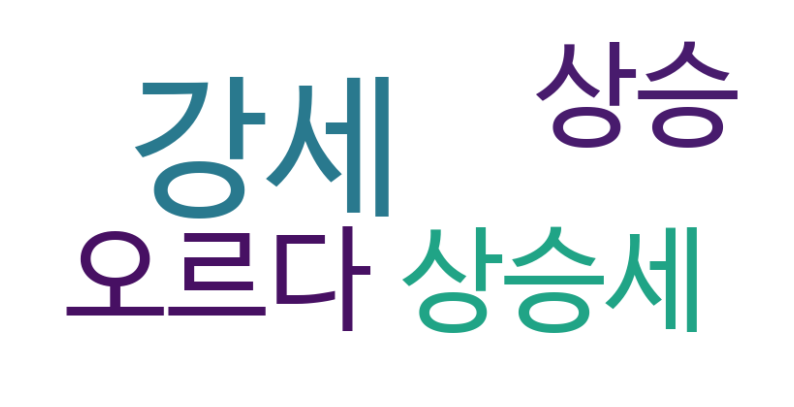

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
font_path = 'NanumBarunGothic.ttf'

# 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
word_freq = dict(zip(positive_word_tf['단어'], positive_word_tf['빈도']))

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 숨기기
plt.show()

In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(2,2))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['positivie_word'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
positive_word_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
positive_word_tf = positive_word_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = positive_word_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
positive_word_tf['비율(%)'] = (positive_word_tf['빈도'] / total_word_count) * 100

positive_word_tf = positive_word_tf.reset_index(drop=True)
positive_word_tf.index = positive_word_tf.index + 1


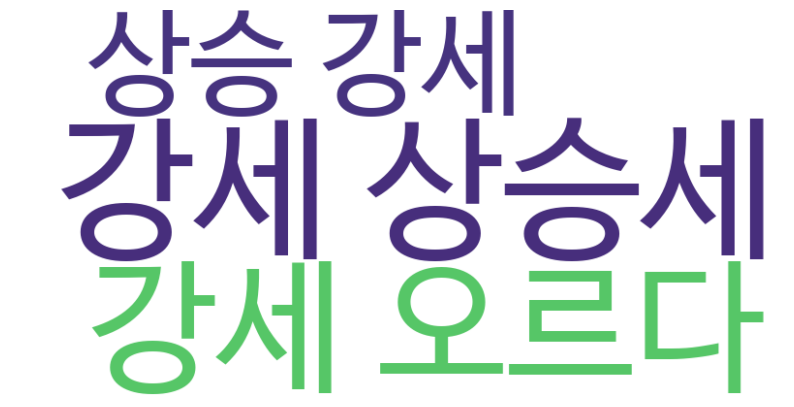

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path = 'NanumBarunGothic.ttf'

# 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
word_freq = dict(zip(positive_word_tf['단어'], positive_word_tf['빈도']))

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 숨기기
plt.show()

부정어휘 비율 추출

In [ ]:
system_prompt='''
다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력에서 부정 어휘를 추출해 주세요.

동사나 형용사는 기본형으로 변형해주세요

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

어휘1, 어휘2, 어휘3 식으로 어휘만 나열해서 답해주세요

부정어휘가 없다면 없음 으로 답해주세요

'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

In [ ]:
correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'negative_word'])


In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(1,1))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['negative_word'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
negative_word_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
negative_word_tf = negative_word_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = negative_word_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
negative_word_tf['비율(%)'] = (negative_word_tf['빈도'] / total_word_count) * 100

negative_word_tf = negative_word_tf.reset_index(drop=True)
negative_word_tf.index = negative_word_tf.index + 1


In [ ]:
# 제외할 단어 리스트 정의
exclude_words = ['없음']  # 제거하고 싶은 단어 리스트를 여기에 추가

# 제외할 단어를 포함하지 않는 데이터만 남김
negative_word_tf = negative_word_tf[~negative_word_tf['단어'].isin(exclude_words)]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
if word_freq:
  font_path = 'NanumBarunGothic.ttf'

  # 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
  word_freq = dict(zip(negative_word_tf['단어'], negative_word_tf['빈도']))

  # 워드 클라우드 생성
  wordcloud = WordCloud(width=800, height=400, background_color='black', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

  # 워드 클라우드 시각화
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # 축 숨기기
  plt.show()

# 기사 주요 토픽 추출

In [ ]:
system_prompt='''
다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력에서 긍정적 토픽과 관련된 토픽어휘들을 추출해 주세요.

동사나 형용사는 기본형으로 변형해주세요

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

답변 형식 : 긍정토픽관련어휘1, 긍정토픽관련어휘2, 긍정토픽관련어휘3

위의 같은 답변형 식으로 기사에서 토픽어휘들만 추출해서 답해주세요

긍정적 토픽과 관련된 토픽어휘가 없다면 없음 으로 답해주세요


'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'positivie_topic_word'])


In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(1,1))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['positivie_topic_word'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
positivie_topic_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
positivie_topic_tf = positivie_topic_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = positivie_topic_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
positivie_topic_tf['비율(%)'] = (positivie_topic_tf['빈도'] / total_word_count) * 100

positivie_topic_tf = positivie_topic_tf.reset_index(drop=True)
positivie_topic_tf.index = positivie_topic_tf.index + 1


In [ ]:
# 제외할 단어 리스트 정의
exclude_words = ['없음']  # 제거하고 싶은 단어 리스트를 여기에 추가

# 제외할 단어를 포함하지 않는 데이터만 남김
positivie_topic_tf = positivie_topic_tf[~positivie_topic_tf['단어'].isin(exclude_words)]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
if word_freq:  # 단어가 있을 때만 워드 클라우드 생성

  font_path = 'NanumBarunGothic.ttf'

  # 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
  word_freq = dict(zip(positivie_topic_tf['단어'], positivie_topic_tf['빈도']))

  # 워드 클라우드 생성
  wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

  # 워드 클라우드 시각화
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # 축 숨기기
  plt.show()

In [ ]:
system_prompt='''
다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력에서 부정적 토픽과 관련된 토픽어휘들을 추출해 주세요.

동사나 형용사는 기본형으로 변형해주세요

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

답변 형식 : 부정토픽관련어휘1, 부정토픽관련어휘2, 부정토픽관련어휘3

위의 같은 답변형 식으로 기사에서 토픽어휘들만 추출해서 답해주세요

부정적 토픽과 관련된 토픽어휘가 없다면 없음 으로 답해주세요


'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'negative_topic_word'])


In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(1,1))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['negative_topic_word'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
negative_topic_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
negative_topic_tf = negative_topic_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = negative_topic_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
negative_topic_tf['비율(%)'] = (negative_topic_tf['빈도'] / total_word_count) * 100

negative_topic_tf = negative_topic_tf.reset_index(drop=True)
negative_topic_tf.index = negative_topic_tf.index + 1


In [ ]:
# 제외할 단어 리스트 정의
exclude_words = ['없음']  # 제거하고 싶은 단어 리스트를 여기에 추가

# 제외할 단어를 포함하지 않는 데이터만 남김
negative_topic_tf = negative_topic_tf[~negative_topic_tf['단어'].isin(exclude_words)]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
if word_freq:  # 단어가 있을 때만 워드 클라우드 생성

  font_path = 'NanumBarunGothic.ttf'

  # 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
  word_freq = dict(zip(negative_topic_tf['단어'], negative_topic_tf['빈도']))

  # 워드 클라우드 생성
  wordcloud = WordCloud(width=800, height=400, background_color='black', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

  # 워드 클라우드 시각화
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # 축 숨기기
  plt.show()

## ChaTGPT를 활용한 NER작업

NER(명명 엔티티 인식)은 텍스트에서 사람, 조직, 장소 등의 특정 개체를 자동으로 식별하고 추출하는 자연어 처리 기술입니다. 이를 통해 중요한 키워드나 정보를 구조적으로 파악할 수 있습니다.



아래 코드는 주식 뉴스 기사에서 사전 정의된 대기업 및 글로벌 트렌드 관련 키워드를 추출하는 ChatGTP를 이용한 NER작업입니다.

In [ ]:
system_prompt='''

사용자 사전 정의

대기업: 삼성,네이버,카카오 등과 같은 국내 대기업, 애플 구글과 같은 글로벌 대기업과 관련된 키워드
글로벌트렌드: 글로벌 수준에서 여러 산업과 사회 부문에 영향을 미치는 종목, 인공지능,사물인터넷, 자율주행,빅데이터 등의 최신 기술 혁신과 관련된 종목


다믐은 네이버 뉴스기사를 수집한 내용입니다.

주어지는 입력에서 사용자 사전에 해당되는 어휘를 추출해주세요

동사나 형용사는 기본형으로 변형해주세요

한줄 한줄씩 한단어 한단어씩 꼼꼼하게 읽고 가장 정확한 판단을 해주세요

답변 형식 : 사용자사전관련어휘1, 사용자사전관련어휘2, 사용자사전관련어휘3

위의 같은 답변형 식으로 기사에서 사용자사전관련 어휘들만 추출해서 답해주세요

사용자사전관련 관련된 토픽어휘가 없다면 없음 으로 답해주세요


'''
def classify_review(review, instruction):
    response = openai.ChatCompletion.create(
        model='gpt-4o',
        messages=[{'role': 'system', 'content': instruction},
                  {'role': 'user', 'content': review}],
        max_tokens=300,
        temperature=0)
    return response.choices[0].message.content

correct = 0
incorrect = 0
results = []

for review in df['title_content']:
    print(review)
    response = classify_review(review, system_prompt)
    print(response)
    print()

    # 리스트에 결과 저장
    results.append([review, response])

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Review', 'impact_keywords'])

In [ ]:
# 단어 빈도 분석
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(max_features=5000, ngram_range=(1,1))  # 상위 5000개 단어
tdm = cv.fit_transform(df_results['impact_keywords'])  # 데이터의 칼럼을 대상으로 빈도수를 계산

# 단어와 빈도를 데이터프레임으로 변환
impact_tf = pd.DataFrame({'단어': cv.get_feature_names_out(), '빈도': tdm.sum(axis=0).flat})

# 빈도수 기준으로 내림차순 정렬
impact_tf = impact_tf.sort_values('빈도', ascending=False)

# 전체 단어 빈도수 합계 계산
total_word_count = impact_tf['빈도'].sum()

# 각 단어의 빈도 비율(%) 계산
impact_tf['비율(%)'] = (impact_tf['빈도'] / total_word_count) * 100

impact_tf = impact_tf.reset_index(drop=True)
impact_tf.index = impact_tf.index + 1


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
if word_freq:  # 단어가 있을 때만 워드 클라우드 생성

  font_path = 'NanumBarunGothic.ttf'

  # 단어와 빈도수를 딕셔너리 형태로 변환 (워드 클라우드에 맞게)
  word_freq = dict(zip(impact_tf['단어'], impact_tf['빈도']))

  # 워드 클라우드 생성
  wordcloud = WordCloud(width=800, height=400, background_color='gray', font_path=font_path, max_words=200).generate_from_frequencies(word_freq)

  # 워드 클라우드 시각화
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # 축 숨기기
  plt.show()

# 종합 분석 리포트

In [ ]:
import openai


# 1. 긍부정 비율 분석 결과
classification_percentages_df = pd.DataFrame(classification_percentages, columns=['Percentage'])

positive_ratio = classification_percentages_df.to_dict()['Percentage']  # 긍부정 비율 데이터를 딕셔너리로 변환

# 2. 긍정 어휘 빈도 연결
positive_words_freq = positive_word_tf['단어'].to_list()[:10]  # 긍정 어휘 상위 10개 추출

# 3. 부정 어휘 빈도 연결
negative_words_freq = negative_word_tf['단어'].to_list()[:10]  # 부정 어휘 상위 10개 추출

# 4. 긍정 토픽 어휘 빈도 연결
positive_topics_freq = positivie_topic_tf['단어'].to_list()[:10]  # 긍정 토픽 상위 10개 추출

# 5. 부정 토픽 어휘 빈도 연결
negative_topics_freq = negative_topic_tf['단어'].to_list()[:10]  # 부정 토픽 상위 10개 추출

# 6. 글로벌 대기업트렌드 관련 어휘 빈도 연결
impact_freq = impact_tf['단어'].to_list()[:10]  # 부정 토픽 상위 10개 추출


# GPT 분석 요청 함수
def generate_analysis_report(positive_ratio, positive_words_freq, negative_words_freq, positive_topics_freq, negative_topics_freq,impact_freq, query):
    system_prompt = f'''
    다믐은 {query} 종목에 관한 오늘자 최신 네이버 뉴스기사를 수집해서  분석한 내용입니다.

    당신은 국내에서 가장 수익률이 좋은 주식투자자입니다.

    아래  {query} 종목에 관한 객관적인 데이터를 바탕으로 해서 해당 종목에 관한 기본적 분석 리포트를 작성해주세요.

    긍부정비율: {classification_percentages}
    긍정어휘: {positive_words_freq}
    부정어휘: {negative_words_freq}
    긍정토픽어휘: {positive_topics_freq}
    부정토픽어휘: {negative_topics_freq}
    대기업 및 글로벌트렌드관련 어휘: {impact_freq}
    '''

    # GPT 요청
    response = openai.ChatCompletion.create(
        model="gpt-4.1",
        messages=[{'role': 'system', 'content': system_prompt}],
        max_tokens=2000,
        temperature=0.3
    )

    return response.choices[0].message.content


# GPT로부터 분석 리포트 생성
report = generate_analysis_report(positive_ratio, positive_words_freq, negative_words_freq, positive_topics_freq, negative_topics_freq, impact_freq, query)

# 결과 출력
print(report)


한국무브넥스(종목코드: 100525)  
기본적 분석 리포트 (2024년 6월  기준)

1. 뉴스 감성 분석 요약
- 긍정: 10%
- 매우 나쁨: 50%
- 부정: 10%
- 중립: 30%

최근 네이버 뉴스 기사에서 한국무브넥스에 대한 부정적 및 매우 부정적(총 60%) 보도가 압도적으로 많았으며, 긍정적 보도는 10%에 불과합니다. 중립적 보도도 30%로 나타나, 투자심리가 전반적으로 위축되어 있음을 알 수 있습니다.

2. 주요 긍·부정 어휘 분석
- 긍정어휘: ‘강세 상승세’, ‘강세 오르다’, ‘상승 강세’
- 부정어휘: ‘하한가’, ‘급락’, ‘부인’, ‘경고’, ‘내리다’, ‘급락세’, ‘하락’, ‘하락세’

최근 뉴스에서는 ‘급락’, ‘하한가’, ‘하락세’ 등 주가의 급격한 하락과 관련된 부정적 표현이 빈번하게 등장하고 있습니다. 반면, ‘강세’, ‘상승세’ 등 긍정적 표현은 상대적으로 적게 나타났습니다.

3. 주요 토픽 어휘
- 긍정: ‘공시’, ‘배당금’, ‘상승’, ‘현금’
- 부정: ‘급락’, ‘하한가’, ‘내리다’, ‘부인’, ‘하락세’

긍정 토픽에서는 배당금, 현금 등 주주환원 정책이나 재무 건전성과 관련된 키워드가 일부 보이나, 부정 토픽에서는 주가 급락, 하한가 등 투자자 입장에서 우려되는 이슈가 두드러집니다.

4. 대기업 및 글로벌 트렌드 관련성
- 대기업 및 글로벌 트렌드 관련 어휘: ‘없음’, ‘oil’, ‘대기업’, ‘삼성’, ‘현대자동차’ 등
- 분석 결과, 한국무브넥스 관련 기사에서는 대기업 및 글로벌 트렌드와의 직접적 연관성이나 협력 이슈가 거의 언급되지 않았습니다.

5. 종합 평가 및 투자 의견

(1) 투자심리  
최근 뉴스 흐름상 투자심리가 매우 위축되어 있습니다. 주가의 급락, 하한가 등 부정적 이슈가 집중적으로 보도되고 있어 단기적 반등 모멘텀은 약한 상황입니다.

(2) 펀더멘털  
배당금, 현금 등 일부 긍정적 재무 키워드가 포착되나, 전반적으로 시장 신뢰를 회복할 만한 강력한 재료는 부족해 보입

## 프롬프트 엔지니어링을 통한 파이썬 코드 작성(주가 기술적 분석)



CoT기반프롬프트 설계

"""삼성전자 주가의 종가와 거래량,등락률을 시각화하는 파이썬 코드를 짜려고 해! 각 단계별로 나누어 진행하되 단계별로 항상 나에게 의견을 물어본 뒤 다음 단계를 진행해줘. 그리고 파이썬 코드 정보는 다음과 같아.
- 단계별로 코랩에서 파이썬 코드를 실행할거야!
- finance-datareader와 matplot 라이브러리 설치 후 사용해줘!
- DataReader 메서드를 사용해줘
- 기간은 최근 6달간을 기준으로 해줘!
- 파이썬 초보자도 쉽게 알 수 있게끔 주석을 달아줘.
- 그래프 라벨은 데이터와 동일한 영어 변수로 해줘!
- 종가,거래량,등략률의 값을 samsung_data 변수에 저장해줘!
"""


In [ ]:
import openai


# GPT 분석 요청 함수
def generate_analysis_report(positive_ratio, positive_words_freq, negative_words_freq, positive_topics_freq, negative_topics_freq,impact_freq, query,samsung_data):
    system_prompt = f'''
    다믐은 {query} 종목에 관한 주가데이터와 내용을 수집해서 분석한 내용입니다.

    당신은  전세계에서 가장 수익율이 높은 최고의 주가투자자 입니다.

    아래  {query} 종목에 관한 기본적,기술적 자료를 바탕으로 해서 투자 분석 리포트를 작성해주세요.

    기본적 분석 데이터(네이버뉴스기사분석 오늘자)

    긍부정비율: {classification_percentages}
    긍정어휘: {positive_words_freq}
    부정어휘: {negative_words_freq}
    긍정토픽어휘: {positive_topics_freq}
    부정토픽어휘: {negative_topics_freq}
    대기업 및 글로벌트렌드관련 어휘: {impact_freq}


    기술적 분석 데이터
    최근 6달간 종가,거래량,등락률: {samsung_data}
    '''

    # GPT 요청
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{'role': 'system', 'content': system_prompt}],
        max_tokens=3000,
        temperature=0.3
    )

    return response.choices[0].message.content

# GPT로부터 분석 리포트 생성
report = generate_analysis_report(positive_ratio, positive_words_freq, negative_words_freq, positive_topics_freq, negative_topics_freq,impact_freq, query,samsung_data)

# 결과 출력
print(report)
